# Generation of training and testing data from models
****
- Data source: Dr. Michel Curé and Catalina Arcos, IFA UV
- Each model is stored in a file with a name like: "t4000g20v10.dat", where
 - t is the effective temperature: 4000 [K]
 - g is 10 times the logarithm of the gravity in [cm/seg^2]: 20/10 = 2.0
 - v_rot is the rotational velocity in [km/seg]: 10
 
- For this analysis we will consider:
 - v_rot >= 100
 - t_eff >= 15000
 - wavelength range [4460, 4480]

- Note that the y axis is the normalized flux


## Needed libraries

In [1]:
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shutil

from sklearn.model_selection import train_test_split


## Functions

In [2]:
def string2params(string, show=True):
    s1 = string.partition("g")
    t = s1[0][1:]
    s2 = s1[2].partition("v")
    g = s2[0]
    v = s2[-1]
    if show:
        print(s1)
        print("t:",t)
        print(s2)
        print("g: ",float(g)/10)
        print("v:", v)
    return float(t), float(g)/10, float(v)

## Files list

In [3]:
files = glob.glob('filtered_wv_models/*')
m = len(files)
print("Number of files in models", m)
print("5 first files: \n", files[0:5])


Number of files in models 5425
5 first files: 
 ['filtered_wv_models/f_t35000g20v280.dat', 'filtered_wv_models/f_t20000g20v260.dat', 'filtered_wv_models/f_t28000g20v350.dat', 'filtered_wv_models/f_t17000g30v170.dat', 'filtered_wv_models/f_t19000g45v220.dat']


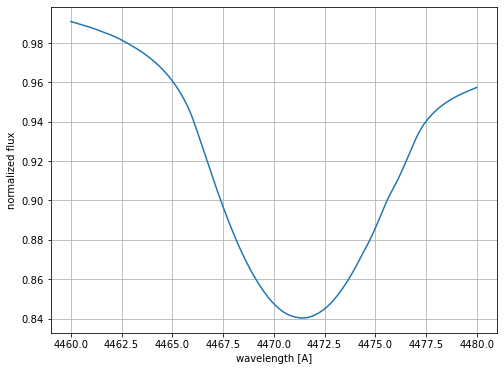

In [4]:
df_line = pd.read_csv("filtered_wv_models/f_t24000g50v370.dat", sep=" ", header=None)

# Plot
plt.figure(figsize=(8,6))
plt.plot(df_line[0].values, df_line[1].values)
plt.xlabel("wavelength [A]")
plt.ylabel("normalized flux")
plt.grid()
plt.show()

## Building X an y matrices
*****

In [5]:
print("--> X has dimension", m, " x 201")
print("--> y has diemsnion", m, " x 3")

--> X has dimension 5425  x 201
--> y has diemsnion 5425  x 3


In [6]:
y = np.zeros((m,3))
df = pd.read_csv(files[0], sep=" ", header=None)
x_points = df[0].values
n_points, n_columns = df.shape
display(df[1].values.shape)
print("Num. of points in x axis: ", n_points)



(201,)

Num. of points in x axis:  201


In [7]:
# X matrix contains the spectral lines
X = np.zeros((m,n_points))
# y matrix contains the labels of each spectral line
y = np.zeros((m,3))
for i,name in enumerate(files):
    file_name = name.split("/")[-1].split(".")[0]
    #print(file_name)
    df = pd.read_csv(name, sep=" ", header=None)
    #print(file_name.split("_")[1])
    t,g,v = string2params(file_name.split("_")[1], show=False)
    X[i,:] = df[1].values
    y[i] = t,g,v
    #print("----")

In [8]:
y=y[:,2]

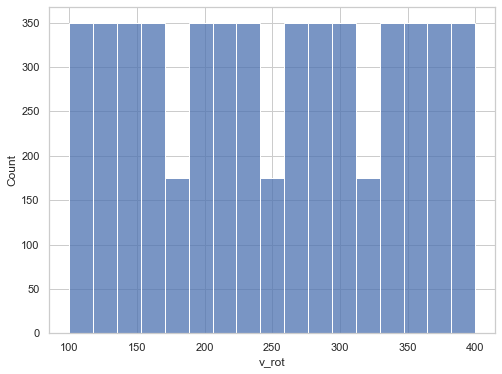

In [11]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")
sns.histplot(data=y,palette='rocket')
plt.xlabel("v_rot")
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix

scaler = StandardScaler()
scaler.fit(X)
X_s = scaler.transform(X)



## Training, testing and validation sets

In [13]:
def train_val_test_split(X, y, train_size, val_size, test_size, random_state = 1):
    if train_size + val_size + test_size != 1.0:
        print("Incorrect sizes!")
        return None
    
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size = val_size/(test_size + train_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_s, y, .8, .1, .1)

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4339, 201) (4339,)
(543, 201) (543,)
(543, 201) (543,)


## Revisar distribución de cada set

## Plots
***

# Convolutional neural network

In [16]:
# about activation functions: https://datascience.stackexchange.com/questions/47751/what-activation-function-should-i-use-for-a-specific-regression-problem

In [17]:
# https://colab.research.google.com/drive/1zjh0tUPYJYgJJunpLC9fW5uf--O0LKeZ?usp=sharing#scrollTo=ud_tq1A0Ffvl

time_steps = X.shape[1]
input_dimension = 1

In [18]:
sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))

In [19]:
print(X_train_reshaped.shape)
print(X_val_reshaped.shape)
print(X_test_reshaped.shape)

(4339, 201, 1)
(543, 201, 1)
(543, 201, 1)


In [20]:
import tensorflow as tf
import keras

In [21]:
def build_conv1D_model():
    n_timesteps = X_train_reshaped.shape[1] #210
    n_features  = X_train_reshaped.shape[2] #1 
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', name="Conv1D_1"))
    model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name="Conv1D_2"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
    model.add(keras.layers.Dense(1, activation= 'relu', name="Dense_4"))


    optimizer = tf.keras.optimizers.RMSprop(0.001)

    l = tf.keras.losses.LogCosh()
    
    model.compile(loss=l,optimizer=optimizer,metrics=['mse'])
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 195, 32)           256       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 193, 16)           1552      
_________________________________________________________________
flatten (Flatten)            (None, 3088)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)                98848     
_________________________________________________________________
Dense_4 (Dense)              (None, 1)                 33        
Total params: 100,689
Trainable params: 100,689
Non-trainable params: 0
_________________________________________________________________


In [22]:
ep = 100
history = model_conv1D.fit(X_train_reshaped, y_train, epochs=ep,
                    validation_data = (X_val_reshaped, y_val), verbose=1)

Epoch 1/100
136/136 [==============================] - 4s 21ms/step - loss: 129.6276 - mse: 25674.5833 - val_loss: 30.8468 - val_mse: 1764.8751
Epoch 2/100
136/136 [==============================] - 1s 10ms/step - loss: 27.3562 - mse: 1469.6335 - val_loss: 14.6843 - val_mse: 551.7766
Epoch 3/100
136/136 [==============================] - 2s 13ms/step - loss: 17.7557 - mse: 662.4073 - val_loss: 18.1770 - val_mse: 787.2473
Epoch 4/100
136/136 [==============================] - 1s 11ms/step - loss: 15.7592 - mse: 560.4946 - val_loss: 13.2027 - val_mse: 421.0642
Epoch 5/100
136/136 [==============================] - 2s 14ms/step - loss: 14.6392 - mse: 506.0328 - val_loss: 13.1425 - val_mse: 421.6626
Epoch 6/100
136/136 [==============================] - 2s 11ms/step - loss: 14.1616 - mse: 468.3865 - val_loss: 11.6487 - val_mse: 424.7960
Epoch 7/100
136/136 [==============================] - 3s 19ms/step - loss: 14.0242 - mse: 457.8858 - val_loss: 11.2250 - val_mse: 344.2380
Epoch 8/100
136

Epoch 60/100
136/136 [==============================] - 1s 11ms/step - loss: 6.7107 - mse: 85.6900 - val_loss: 5.4253 - val_mse: 56.8800
Epoch 61/100
136/136 [==============================] - 2s 12ms/step - loss: 6.7508 - mse: 86.8192 - val_loss: 9.2291 - val_mse: 138.0292
Epoch 62/100
136/136 [==============================] - 2s 12ms/step - loss: 6.6649 - mse: 85.4166 - val_loss: 3.9505 - val_mse: 39.2077
Epoch 63/100
136/136 [==============================] - 2s 12ms/step - loss: 6.3841 - mse: 79.0377 - val_loss: 7.1883 - val_mse: 92.8268
Epoch 64/100
136/136 [==============================] - 2s 13ms/step - loss: 6.6514 - mse: 84.3046 - val_loss: 6.7275 - val_mse: 83.2943
Epoch 65/100
136/136 [==============================] - 1s 10ms/step - loss: 6.6682 - mse: 84.2298 - val_loss: 2.9575 - val_mse: 24.4178
Epoch 66/100
136/136 [==============================] - 1s 10ms/step - loss: 6.2680 - mse: 79.8331 - val_loss: 5.5439 - val_mse: 60.3462
Epoch 67/100
136/136 [==================

In [23]:
[loss, mae] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae))

Testing set Mean Abs Error:   89.79


In [24]:
pred =model_conv1D.predict(X_test_reshaped)

In [26]:
train_loss = history.history['loss']


In [27]:
val_loss = history.history['val_loss']


In [28]:
def plot_train_val(A, B, n, xlabel, ylabel, title):
    plt.figure(1, figsize=(10, 6))
    plt.plot(range(n),A)
    plt.plot(range(n),B)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(['Training', 'Validation'])
    plt.show()

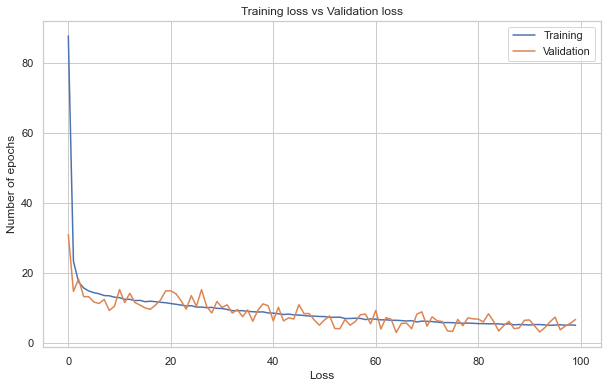

In [29]:

plot_train_val(train_loss, val_loss, ep, 'Loss', 'Number of epochs', 'Training loss vs Validation loss')

In [30]:
from sklearn.metrics import mean_absolute_error

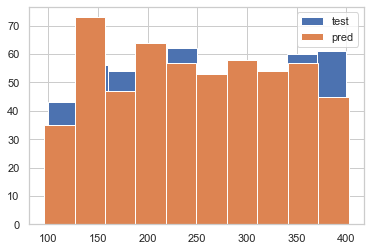

In [31]:
plt.figure()
plt.hist(y_test, label="test")
plt.hist(pred, label="pred")
plt.legend(loc="best")
plt.show()


In [32]:
mean_absolute_error(y_test, pred)

7.379092839980433

# BeSoS lines

In [34]:
df = pd.read_csv("BESOS/2_Be_stars/HD33328/PUCHEROS/hd33328_2013-02-26_00-55-34_final_corr.txt", sep="\t", header=None)

m1 = df[0] >= 4460
m2 = df[0] <= 4480

df2 = df[m1][m2]

<ipython-input-34-e153e34589ad>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[m1][m2]


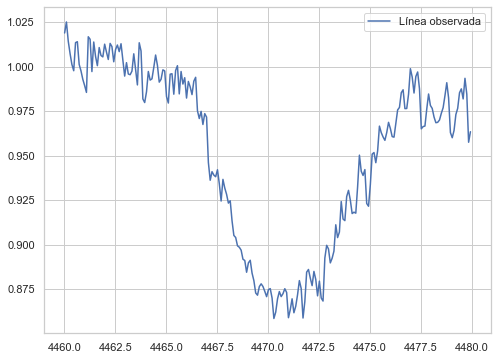

In [36]:
plt.figure(figsize=(8,6))
plt.plot(df2[0], df2[1], label="Línea observada")
#plt.plot(df4[0], df4[1], label="Modelo")
plt.legend(loc="best")
plt.show()

In [37]:
n = 201  # for 2 random indices
index = np.random.choice(df2[0].shape[0], n, replace=False) 

In [38]:
index.sort()

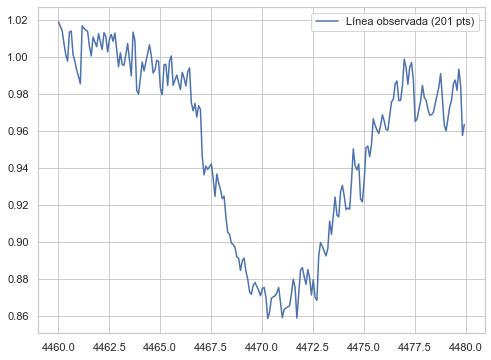

predicted v_rot: [[169.24629]]


In [40]:
obs_waves = df2[0].values[index]

obs_flux = df2[1].values[index]

plt.figure(figsize=(8,6))
plt.plot(obs_waves, obs_flux, label="Línea observada (201 pts)")
#plt.plot(df4[0], df4[1], label="Modelo")
plt.legend(loc="best")
plt.show()

obs_flux_inv= scaler.transform(obs_flux.reshape(1,201))

obs_flux_reshaped = obs_flux_inv.reshape((1, time_steps, input_dimension))

pred_obs =model_conv1D.predict(obs_flux_reshaped)


print("predicted v_rot:", pred_obs)